# Meta-model Design

## Imports

In [1]:
# for colab run
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/projeto/automl-dynamic-search-space/analysis/meta-model-design/")

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# COLORS = ["#333333", "#999ea2", "#6fa2d0", "#4d759a", "#073763"][::-1]
# COLORS = ["#1B262C", "#0F4C75", "#3282B8", "#BBE1FA"]
COLORS = ["#000057", "#4d759a", "#3282B8",  "#999ea2", "#4f4f4f", "#1B262C"]

MY_PALLETE = sns.color_palette("colorblind")
sns.set_palette(MY_PALLETE)

In [4]:

MY_PALLETE

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Meta-dataset

In [5]:
def generate_meta_dataset(D_train, d_test, meta_knowledge, meta_target, meta_feature):
  minn = -1e10
  maxx = 1e10

  # fill pipeline without performance with 0
  # fill nan meta-feature with 0 and replace +-inf
  meta_dataset_ = meta_target.fillna(0)\
    .merge(
        meta_feature\
          .replace([np.inf], maxx)\
          .replace([-np.inf], minn),
        how="inner", on="dataset")\
    .fillna(0.0)

  aux_cl, aux_pr, aux_p = pipeline_statistics_meta_features(
        meta_knowledge, exclusion_list=d_test)

  # fill nan performance with 0
  meta_dataset_ = meta_dataset_\
    .merge(aux_cl, on="classifier", how="left")\
    .merge(aux_pr, on="preprocessor", how="left")\
    .merge(aux_p, on=["classifier", "preprocessor"], how="left")\
    .fillna(0.0)

  meta_dataset_["classifier-num"] = meta_dataset_["classifier"].astype("category").cat.codes
  meta_dataset_["preprocessor-num"] = meta_dataset_["preprocessor"].astype("category").cat.codes

  train_idx = meta_dataset_["dataset"].isin(D_train)
  test_idx = meta_dataset_["dataset"].isin(d_test)

  return meta_dataset_[train_idx], meta_dataset_[test_idx]

### Pipeline Statistics Meta Feature

In [7]:
def pipeline_statistics_meta_features(meta_knowledge, exclusion_list=None):
  """ Use exclusion_list with list of dataset to remove."""

  if exclusion_list:
    idx = ~meta_knowledge["dataset"].isin(exclusion_list)
    meta_knowledge = meta_knowledge[idx]

  aux_cl = meta_knowledge \
      .groupby(["classifier"]) \
      .agg(
          cl_min_perf=("median_perf", "min"),
          cl_max_perf=("median_perf", "max"),
          cl_median_perf=("median_perf", "median"),
          cl_mean_perf=("median_perf", "mean"),
          cl_std_perf=("median_perf", "std")
      )

  aux_pr =  meta_knowledge \
      .groupby(["preprocessor"]) \
      .agg(
          pr_min_perf=("median_perf", "min"),
          pr_max_perf=("median_perf", "max"),
          pr_median_perf=("median_perf", "median"),
          pr_mean_perf=("median_perf", "mean"),
          pr_std_perf=("median_perf", "std")
      )

  aux_p =  meta_knowledge \
      .groupby(["classifier", "preprocessor"]) \
      .agg(
          p_min_perf=("median_perf", "min"),
          p_max_perf=("median_perf", "max"),
          p_median_perf=("median_perf", "median"),
          p_mean_perf=("median_perf", "mean"),
          p_std_perf=("median_perf", "std")
      )

  return aux_cl, aux_pr, aux_p

# Experimental Setup

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import make_scorer
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

In [9]:
D = ['dataset_1039',
 'dataset_1044',
 'dataset_1046',
 'dataset_1049',
 'dataset_1050',
 'dataset_1053',
 'dataset_1056',
 'dataset_1063',
 'dataset_1068',
 'dataset_1069',
 'dataset_11',
 'dataset_1116',
 'dataset_1120',
 'dataset_1128',
 'dataset_1130',
 'dataset_1134',
 'dataset_1142',
 'dataset_1146',
 'dataset_1161',
 'dataset_1166',
 'dataset_1233',
 'dataset_1457',
 'dataset_1459',
 'dataset_1462',
 'dataset_1466',
 'dataset_1471',
 'dataset_1475',
 'dataset_1478',
 'dataset_1479',
 'dataset_1480',
 'dataset_1481',
 'dataset_1483',
 'dataset_1485',
 'dataset_1487',
 'dataset_1491',
 'dataset_1494',
 'dataset_1496',
 'dataset_1497',
 'dataset_15',
 'dataset_1501',
 'dataset_1502',
 'dataset_1503',
 'dataset_1507',
 'dataset_1509',
 'dataset_151',
 'dataset_1510',
 'dataset_1515',
 'dataset_1528',
 'dataset_1529',
 'dataset_1530',
 'dataset_1531',
 'dataset_1532',
 'dataset_1535',
 'dataset_1536',
 'dataset_1538',
 'dataset_1541',
 'dataset_1542',
 'dataset_1547',
 'dataset_1549',
 'dataset_155',
 'dataset_1552',
 'dataset_1553',
 'dataset_1590',
 'dataset_181',
 'dataset_182',
 'dataset_184',
 'dataset_185',
 'dataset_188',
 'dataset_2',
 'dataset_23',
 'dataset_23380',
 'dataset_23381',
 'dataset_24',
 'dataset_26',
 'dataset_279',
 'dataset_28',
 'dataset_30',
 'dataset_300',
 'dataset_307',
 'dataset_310',
 'dataset_311',
 'dataset_32',
 'dataset_333',
 'dataset_334',
 'dataset_335',
 'dataset_37',
 'dataset_375',
 'dataset_377',
 'dataset_40496',
 'dataset_40498',
 'dataset_40499',
 'dataset_40536',
 'dataset_40646',
 'dataset_40647',
 'dataset_40648',
 'dataset_40649',
 'dataset_40650',
 'dataset_40668',
 'dataset_40670',
 'dataset_40672',
 'dataset_40677',
 'dataset_40680',
 'dataset_40691',
 'dataset_40693',
 'dataset_40701',
 'dataset_40704',
 'dataset_40705',
 'dataset_40706',
 'dataset_40900',
 'dataset_40922',
 'dataset_40966',
 'dataset_40971',
 'dataset_40982',
 'dataset_40983',
 'dataset_40985',
 'dataset_40994',
 'dataset_41082',
 'dataset_41084',
 'dataset_41144',
 'dataset_41145',
 'dataset_41146',
 'dataset_41150',
 'dataset_41162',
 'dataset_41163',
 'dataset_4134',
 'dataset_41671',
 'dataset_41972',
 'dataset_41989',
 'dataset_41990',
 'dataset_42',
 'dataset_42193',
 'dataset_44',
 'dataset_451',
 'dataset_4534',
 'dataset_4538',
 'dataset_4541',
 'dataset_458',
 'dataset_46',
 'dataset_469',
 'dataset_470',
 'dataset_50',
 'dataset_57',
 'dataset_6',
 'dataset_60',
 'dataset_6332',
 'dataset_715',
 'dataset_717',
 'dataset_722',
 'dataset_725',
 'dataset_727',
 'dataset_728',
 'dataset_734',
 'dataset_735',
 'dataset_737',
 'dataset_740',
 'dataset_742',
 'dataset_750',
 'dataset_752',
 'dataset_757',
 'dataset_761',
 'dataset_770',
 'dataset_772',
 'dataset_799',
 'dataset_802',
 'dataset_803',
 'dataset_807',
 'dataset_816',
 'dataset_819',
 'dataset_821',
 'dataset_823',
 'dataset_825',
 'dataset_826',
 'dataset_833',
 'dataset_837',
 'dataset_839',
 'dataset_841',
 'dataset_846',
 'dataset_847',
 'dataset_871',
 'dataset_881',
 'dataset_884',
 'dataset_886',
 'dataset_897',
 'dataset_901',
 'dataset_903',
 'dataset_920',
 'dataset_923',
 'dataset_930',
 'dataset_934',
 'dataset_936',
 'dataset_937',
 'dataset_940',
 'dataset_947',
 'dataset_949',
 'dataset_950',
 'dataset_951',
 'dataset_981']

SEED=10
SEEDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # for repetition
D_train, d_test = train_test_split(D, test_size=0.20, shuffle=True, random_state=SEED)
CV = 10

def rrmse(y_true, y_pred):
  return np.sqrt(np.sum(np.power(y_true - y_pred, 2)) / np.sum(np.power(y_true - np.mean(y_true), 2)))

MEASURES = {
    "mse": make_scorer(mean_squared_error),
    "rmse": make_scorer(root_mean_squared_error),
    "rrmse": make_scorer(rrmse),
    "r2": make_scorer(r2_score),
    "mape": make_scorer(mean_absolute_percentage_error)
}


In [10]:
meta_target = pd.read_csv("meta-target-pipeline-f1-weighted.csv")
meta_feature = pd.read_csv("../meta-feature-analysis/meta_feature_dataset.csv")
meta_knowledge = pd.read_csv("meta_knowledge_cv_f1_weighted.csv")

/tmp/ipython-input-10-1514581220.py:3: DtypeWarning: Columns (197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_knowledge = pd.read_csv("meta_knowledge_cv_f1_weighted.csv")


In [11]:
METAFEATURES_GENERAL = [
 'attr_to_inst',
 'cat_to_num',
 'freq_class.mean',
 'freq_class.sd',
 'inst_to_attr',
 'nr_attr',
 'nr_bin',
 'nr_cat',
 'nr_class',
 'nr_inst',
 'nr_num',
 'num_to_cat'
]
METAFEATURES_INFO_THEORY = [
  'attr_conc.mean',
 'attr_conc.sd',
 'attr_ent.mean',
 'attr_ent.sd',
 'class_conc.mean',
 'class_conc.sd',
 'class_ent',
 'eq_num_attr',
 'joint_ent.mean',
 'joint_ent.sd',
 'mut_inf.mean',
 'mut_inf.sd',
 'ns_ratio',

]
METAFEATURES_MODEL_BASED = [
  'leaves',
 'leaves_branch.mean',
 'leaves_branch.sd',
 'leaves_corrob.mean',
 'leaves_corrob.sd',
 'leaves_homo.mean',
 'leaves_homo.sd',
 'leaves_per_class.mean',
 'leaves_per_class.sd',
 'nodes',
 'nodes_per_attr',
 'nodes_per_inst',
 'nodes_per_level.mean',
 'nodes_per_level.sd',
 'nodes_repeated.mean',
 'nodes_repeated.sd',
 'tree_depth.mean',
 'tree_depth.sd',
 'tree_imbalance.mean',
 'tree_imbalance.sd',
 'tree_shape.mean',
 'tree_shape.sd',
  'var_importance.mean',
 'var_importance.sd',
]
METAFEATURES_LANDMARKING = [
  'best_node.mean',
  'best_node.sd',
  'elite_nn.mean',
  'elite_nn.sd',
  'linear_discr.mean',
  'linear_discr.sd',
  'naive_bayes.mean',
  'naive_bayes.sd',
  'one_nn.mean',
  'one_nn.sd',
  'random_node.mean',
  'random_node.sd',
  'worst_node.mean',
  'worst_node.sd',
]
METAFEATURES_STATISTICAL = [
 'can_cor.mean',
 'can_cor.sd',
 'cor.mean',
 'cor.sd',
 'cov.mean',
 'cov.sd',
 'eigenvalues.mean',
 'eigenvalues.sd',
 'g_mean.mean',
 'g_mean.sd',
 'gravity',
 'h_mean.mean',
 'h_mean.sd',
 'iq_range.mean',
 'iq_range.sd',
 'kurtosis.mean',
 'kurtosis.sd',
 'lh_trace',
 'mad.mean',
 'mad.sd',
 'max.mean',
 'max.sd',
 'mean.mean',
 'mean.sd',
 'median.mean',
 'median.sd',
 'min.mean',
 'min.sd',
 'nr_cor_attr',
 'nr_disc',
 'nr_norm',
 'nr_outliers',
 'p_trace',
 'range.mean',
 'range.sd',
 'roy_root',
 'sd.mean',
 'sd.sd',
 'sd_ratio',
 'skewness.mean',
 'skewness.sd',
 'sparsity.mean',
 'sparsity.sd',
 't_mean.mean',
 't_mean.sd',
 'var.mean',
 'var.sd',
 'w_lambda',
]

NEW_METAFEATURES = [ # new meta feature bellow
 'cl_min_perf',
 'cl_max_perf',
 'cl_median_perf',
 'cl_mean_perf',
 'cl_std_perf',
 'pr_min_perf',
 'pr_max_perf',
 'pr_median_perf',
 'pr_mean_perf',
 'pr_std_perf',
 'p_min_perf',
 'p_max_perf',
 'p_median_perf',
 'p_mean_perf',
 'p_std_perf',
 'classifier-num',
 'preprocessor-num'
]


METAFEATURES_ALL  = METAFEATURES_GENERAL\
  + METAFEATURES_INFO_THEORY\
  + METAFEATURES_MODEL_BASED\
  + METAFEATURES_LANDMARKING\
  + METAFEATURES_STATISTICAL\
  + NEW_METAFEATURES

METACLASS = 'f1_weighted_test'

HIGH_01_s = [
 'attr_conc.mean',
 'attr_conc.sd',
 'best_node.mean',
 'best_node.sd',
 'class_conc.mean',
 'class_conc.sd',
 'elite_nn.mean',
 'elite_nn.sd',
 'kurtosis.mean',
 'kurtosis.sd',
 'linear_discr.mean',
 'linear_discr.sd',
 'naive_bayes.mean',
 'naive_bayes.sd',
 'one_nn.mean',
 'one_nn.sd',
 'random_node.mean',
 'random_node.sd',
 'skewness.mean',
 'skewness.sd',
 'sparsity.mean',
 'sparsity.sd',
 'worst_node.mean',
 'worst_node.sd',
]

In [12]:
def feature_importance_filter(model, features, n=-1, seed=0):
  importances = model.feature_importances_
  indices = np.argsort(importances)[::-1] # best on top
  return np.array(features)[indices[:n]].tolist()

def meta_model(X_train, y_train, n, seed):
  fs = Pipeline([('rf', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=seed), func=np.log1p, inverse_func=np.expm1))])
  fs.fit(X_train, y_train)
  features = feature_importance_filter(fs["rf"].regressor_, X_train.columns.to_list(), n=n, seed=seed)

  model = Pipeline([('RF', TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=seed), func=np.log1p, inverse_func=np.expm1))])
  model.fit(X_train[features], y_train)

  return model, features

def save_pdf(name, g, extention=".pdf", path="./"):
  g.savefig(path+name+extention)

def plot_feature_importance(meta_model, meta_features, model_name=None):
  fig, ax = plt.subplots(figsize=(7, 4))

  importances = meta_model["RF"].regressor_.feature_importances_
  indices = np.argsort(importances)[::-1] # higher first

  aux = pd.DataFrame({"meta-feature": [meta_features[i] for i in indices], "relative importance": importances[indices]})
  g = sns.barplot(aux, x="meta-feature", y="relative importance")
  plt.xticks(rotation=90)
  plt.tight_layout()
  save_pdf(f"feature_importance_{model_name}", g.figure, extention=".pdf", path="./")


## Experiment: Meta-learners


In [13]:
# D_train_meta, d_test_meta = generate_meta_dataset(D_train, d_test, meta_knowledge, meta_target, meta_feature)
# D_train_meta.to_csv("D_train_meta", index=False)
# d_test_meta.to_csv("d_test_meta", index=False)

In [ ]:
# split dataset set
D_train_meta, d_test_meta = generate_meta_dataset(D_train, d_test, meta_knowledge, meta_target, meta_feature)
D_train_meta.to_csv("D_train_meta", index=False)
d_test_meta.to_csv("d_test_meta", index=False)

X_train = D_train_meta[METAFEATURES_ALL]
y_train = D_train_meta[METACLASS]

meta_model_25_all, meta_features_25_all = meta_model(X_train, y_train, 25, SEED)

X_test = d_test_meta[meta_features_25_all]
y_test = d_test_meta[METACLASS]

for k, v in MEASURES.items():
  score =  v(estimator=meta_model_25_all, X=X_test, y_true=y_test)
  print(f"{k}: {score}")

mse: 0.03362791458436527
rmse: 0.18337915526134718
rrmse: 0.5903003815344922
r2: 0.651545459560233
mape: 65443397179858.6


In [ ]:
meta_model_25_all

Pipeline(steps=[('RF',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(random_state=10)))])

In [ ]:
meta_features_25_all

['nodes_per_inst',
 'p_max_perf',
 'p_mean_perf',
 'p_median_perf',
 'p_min_perf',
 'linear_discr.mean',
 'p_std_perf',
 'nr_cat',
 'one_nn.mean',
 'pr_std_perf',
 'attr_ent.mean',
 'preprocessor-num',
 'class_ent',
 'classifier-num',
 'pr_median_perf',
 'best_node.mean',
 'pr_mean_perf',
 'cl_median_perf',
 'cl_std_perf',
 'cl_mean_perf',
 'sparsity.mean',
 'pr_min_perf',
 'joint_ent.mean',
 'cl_min_perf',
 'w_lambda']

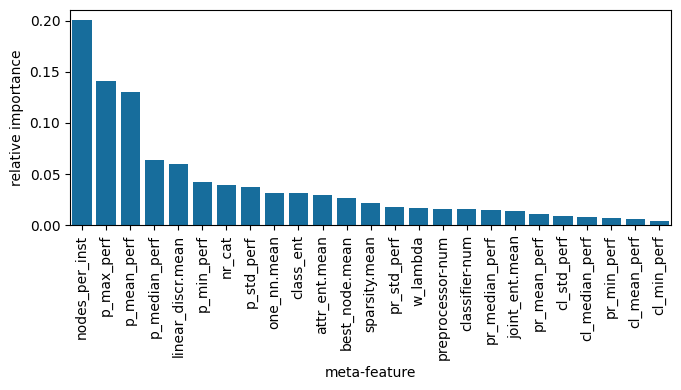

In [ ]:
plot_feature_importance(meta_model_25_all, meta_features_25_all, "meta_model_25_all")

## Experiment: Meta-learners (removed)

In [ ]:
# split dataset set
D_train_meta, d_test_meta = generate_meta_dataset(D_train, d_test, meta_knowledge, meta_target, meta_feature)

METAFEATURES_ALL_REF = [x for x in METAFEATURES_ALL if x not in HIGH_01_s]

X_train = D_train_meta[METAFEATURES_ALL_REF]
y_train = D_train_meta[METACLASS]

meta_model_25_rem, meta_features_25_rem = meta_model(X_train, y_train, 25, SEED)

X_test = d_test_meta[meta_features_25_rem]
y_test = d_test_meta[METACLASS]

for k, v in MEASURES.items():
  score =  v(estimator=meta_model_25_rem, X=X_test, y_true=y_test)
  print(f"{k}: {score}")

mse: 0.03247067055095111
rmse: 0.1801962001568044
rrmse: 0.580054399051145
r2: 0.663536894141415
mape: 60316010713011.42


In [ ]:
meta_model_25_rem

Pipeline(steps=[('RF',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(random_state=10)))])

In [ ]:
meta_features_25_rem

['nodes_per_inst',
 'p_mean_perf',
 'p_max_perf',
 'p_median_perf',
 'p_min_perf',
 'joint_ent.mean',
 'p_std_perf',
 'nr_cat',
 'class_ent',
 'attr_ent.mean',
 'pr_std_perf',
 'preprocessor-num',
 'classifier-num',
 'pr_median_perf',
 'pr_mean_perf',
 'cl_median_perf',
 'cl_std_perf',
 'pr_min_perf',
 'cl_mean_perf',
 'nr_num',
 'w_lambda',
 'var_importance.sd',
 'attr_to_inst',
 'nr_attr',
 'freq_class.sd']

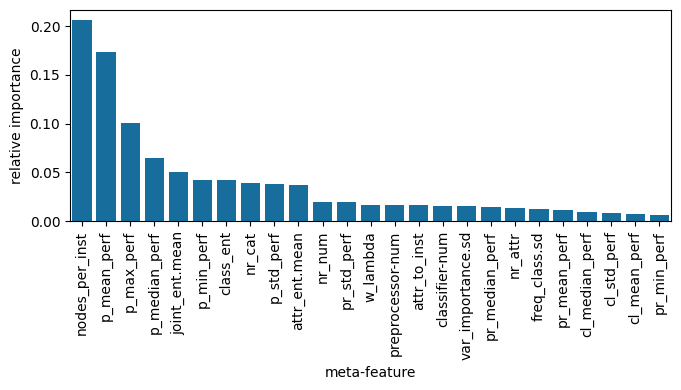

In [ ]:
plot_feature_importance(meta_model_25_rem, meta_features_25_rem, "meta_model_25_rem")

## Shapp Analysis

In [ ]:
# !pip install shap

In [ ]:
import shap
import pickle

In [ ]:
rf_model = meta_model_25_rem["RF"].regressor_

In [ ]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)


In [ ]:
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [ ]:
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [ ]:
shap_values.max()

0.16337465946941068

In [ ]:
np.expm1(shap_values).max()

0.17747776025057457

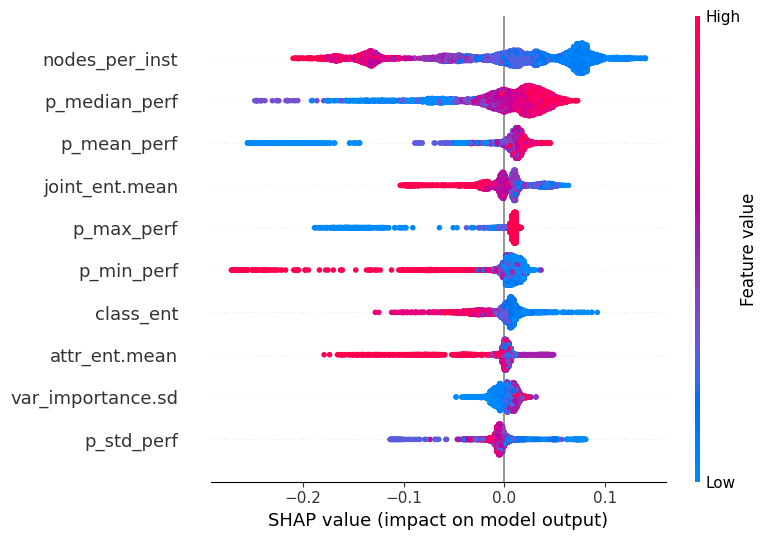

In [ ]:
shap.summary_plot(np.expm1(shap_values), X_test, show=False, max_display=10)
plt.savefig("shap_summary.pdf",dpi=700)
plt.show()

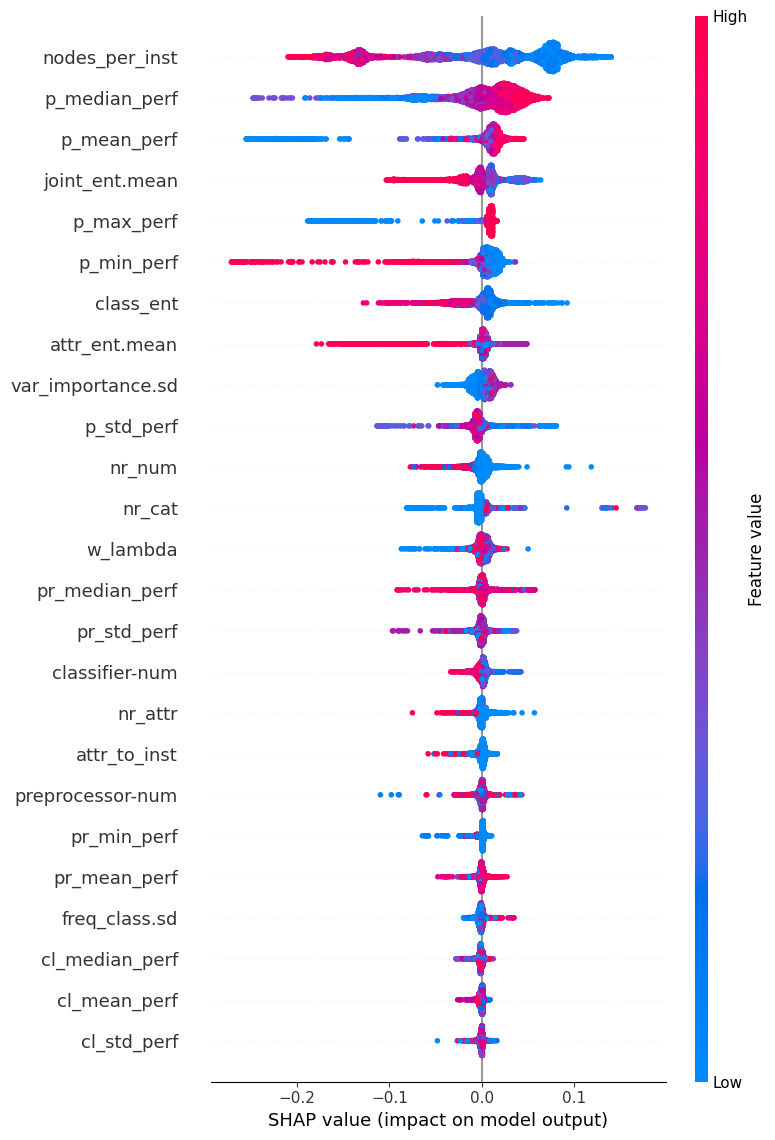

In [ ]:
shap.summary_plot(np.expm1(shap_values), X_test, show=False, max_display=25)
plt.savefig("shap_summary_all.pdf",dpi=700)
plt.show()

# Save Model

In [ ]:
def save_meta_model(obj, name):
  with open(name, 'wb') as f:
      pickle.dump(obj, f)


def load_meta_model(name):
  with open(name, 'rb') as f:
      return pickle.load(f)


In [ ]:
save_meta_model((meta_model_25_rem, meta_features_25_rem), "meta_model_25_rem.pkl")

In [ ]:
save_meta_model((meta_model_25_all, meta_features_25_all), "meta_model_25_all.pkl")